<h1 style="text-align: center;">Feature Engineering & Orthogonalization</h1>

# 1. Setup & Loading Data

In [1]:
import os
from pathlib import Path

repo_root = Path.cwd()

while not (repo_root / ".git").exists() and repo_root.parent != repo_root:
    repo_root = repo_root.parent

os.chdir(repo_root)
print(f"Current working directory set to: {repo_root}")

Current working directory set to: c:\Users\Lenovo\Desktop\Git Uploads\cross-currency-extrema-forecasting


In [ ]:
from src.features import FeatureCalculator
from src.features import FeatureSelector
from src.data.split_data import DatasetSplitter
from utils.helpers import check_stationarity, stationarize_by_currency
import pandas as pd

df = pd.read_parquet("data/processed/labeled_data.parquet")

# 2. Feature Engineering & Downsampling

In [3]:
fc = FeatureCalculator(df)
df_features = fc.compute_all_features()

🕒 Starting feature computations...
📊 Computing return figures...
📊 Computing volatility metrics...
📊 Computing microstructure features...
📊 Computing technical indicators...
📊 Computing time features...
📊 Aligning & downsampling to 15mins intervals...
✅ Downsampled dataset from 2,678,400 rows to 178,560 rows using 15-minute intervals.
✅ All features computed.



# 3. Checking for Stationarity

In [4]:
stationary_mask = check_stationarity(df_features, 0.1)
stationary_mask

Running ADF test for AUDJPY...
Running ADF test for AUDSGD...
Running ADF test for AUDUSD...
Running ADF test for EURAUD...
Running ADF test for EURGBP...
Running ADF test for EURJPY...
Running ADF test for EURUSD...
Running ADF test for GBPJPY...
Running ADF test for GBPUSD...
Running ADF test for NZDUSD...
Running ADF test for SGDJPY...
Running ADF test for USDCAD...
Running ADF test for USDCHF...
Running ADF test for USDJPY...
Running ADF test for USDZAR...


,y_high,currency,y_low,log_ret,cum_ret,vol_adj_ret,rv_60,atr,hl_spread,co_ret,rel_vol,rsi,macd_hist,sma_60,sin_minute,cos_minute,sin_hour,cos_hour
0,False,AUDJPY,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True
1,True,AUDSGD,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2,True,AUDUSD,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
3,True,EURAUD,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
4,False,EURGBP,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True
5,False,EURJPY,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True
6,True,EURUSD,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
7,False,GBPJPY,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True
8,True,GBPUSD,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
9,True,NZDUSD,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


In [5]:
non_stationary = [
    col
    for col in stationary_mask.columns
    if col != "currency"
    and not stationary_mask[col].all()
    and col in df_features.columns
]
non_stationary

['y_high', 'y_low', 'sma_60']

In [6]:
df_features = stationarize_by_currency(df_features, non_stationary)

# 4. Orthogonalizing Features

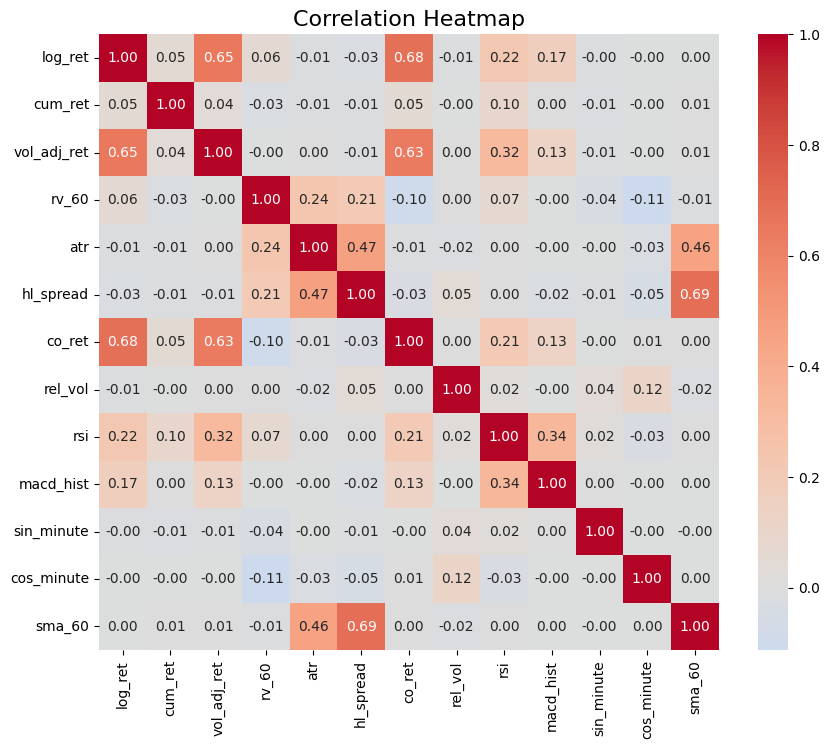

In [7]:
from utils.viz import plot_corr_heatmap


feature_cols = [
    "log_ret",
    "cum_ret",
    "vol_adj_ret",
    "rv_60",
    "atr",
    "hl_spread",
    "co_ret",
    "rel_vol",
    "rsi",
    "macd_hist",
    "sin_minute",
    "cos_minute",
    "sma_60",
]

targets = [
    "D_y_high",
    "D_y_low",
]

plot_corr_heatmap(df_features[feature_cols])

In [8]:
orth_dfs = []
pls = {}
for curr in df_features["currency"].unique():
    df_curr = df_features[df_features["currency"] == curr]
    print(f"---------{curr}---------")
    feature_selector = FeatureSelector(
        df_curr,
        feature_cols=feature_cols,
        targets=targets,
    )

    orth_dfs.append(feature_selector.orthogonalize_features())
    # feature_selector.plot_mrmr_heatmaps()
    # pls_curr = feature_selector.select_pls_components(corr_threshold=0.2)
    # print(pls_curr, "\n")
    # pls[curr] = pls_curr

df_orthogonal = pd.concat(orth_dfs, ignore_index=False).reset_index()

---------AUDJPY---------
🔹 Performing PLS-based orthogonalization...
✅ Orthogonalized 13 features into 13 PLS components.
---------AUDSGD---------
🔹 Performing PLS-based orthogonalization...
✅ Orthogonalized 13 features into 13 PLS components.
---------AUDUSD---------
🔹 Performing PLS-based orthogonalization...
✅ Orthogonalized 13 features into 13 PLS components.
---------EURAUD---------
🔹 Performing PLS-based orthogonalization...
✅ Orthogonalized 13 features into 13 PLS components.
---------EURGBP---------
🔹 Performing PLS-based orthogonalization...
✅ Orthogonalized 13 features into 13 PLS components.
---------EURJPY---------
🔹 Performing PLS-based orthogonalization...
✅ Orthogonalized 13 features into 13 PLS components.
---------EURUSD---------
🔹 Performing PLS-based orthogonalization...
✅ Orthogonalized 13 features into 13 PLS components.
---------GBPJPY---------
🔹 Performing PLS-based orthogonalization...
✅ Orthogonalized 13 features into 13 PLS components.
---------GBPUSD---------

In [9]:
orth_features = [col for col in df_orthogonal.columns if col.startswith("pls")]

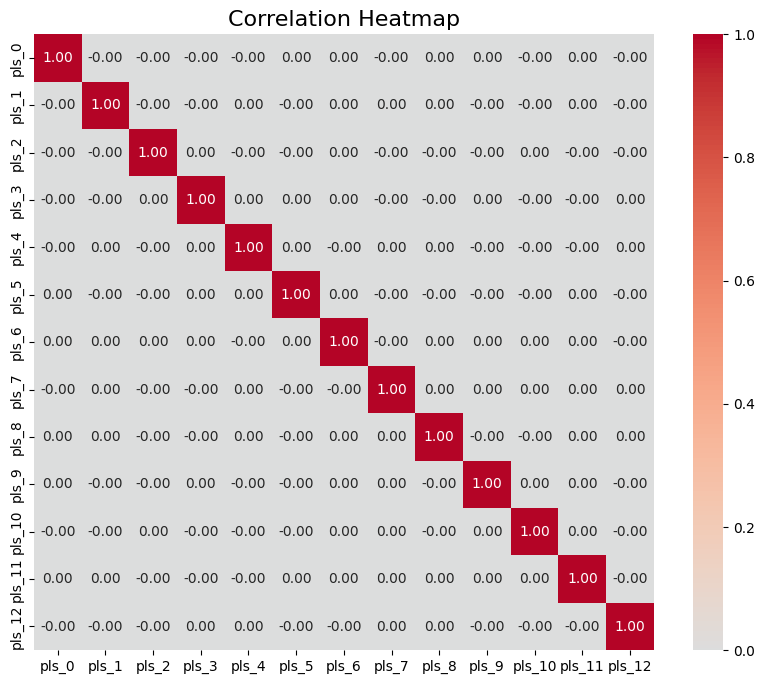

In [16]:
plot_corr_heatmap(df_orthogonal[orth_features])

# 5. Splitting & Saving Datasets

In [17]:
df_final = df_orthogonal[
    [
        "open_time",
        "currency",
        "D_y_high",
        "D_y_low",
        "y_high",
        "y_low",
    ]
    + orth_features
]

In [18]:
df_final.to_parquet("data/processed/final_features.parquet", index=True)

In [19]:
data_splitter = DatasetSplitter()
train, val, test = data_splitter.split(df_final)

🔹 Splitting dataset by currency with embargo...
✅ Split dataset: 124,980 train | 26,775 val | 23,235 test (embargo ~1.00% per currency)


In [20]:
train.to_parquet("data/split/train.parquet", index=True)
val.to_parquet("data/split/val.parquet", index=True)
test.to_parquet("data/split/test.parquet", index=True)